In [1]:
# use magic to install all pylab functions (allows easy definition of n-dimensional empty arrays)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [23]:
# import libraries
import pulp as lp
import numpy as np
import networkx as nx
from networkx.drawing.nx_pydot import write_dot

In [3]:
# Set params
order = 9
degree = 4

In [4]:
# Assumed params
l = 1
m = 2

In [5]:
# only interested in feasibility, so trivial objective
graphprob = lp.LpProblem(name="SRG({},{},{},{})_problem".format(order,degree,l,m), sense=lp.LpMinimize)
graphprob += 0, "feasibility_obj"

In [6]:
# define variables to indicate if vertices i,j are neighbours
edge_variables = empty((order,order), dtype='object')
for i in range(order):
    for j in range(order):
        name = 'A_{},{}'.format(str(i + 1), str(j + 1))
        var = lp.LpVariable(name, cat='Binary')
        edge_variables[i,j] = var

In [7]:
# define variables to indicate when vertex k is a mutual neighbour of vertices i<j
mutual_variables=empty((order,order,order), dtype='object')
for i in range(order):
    for j in range(order):
        for k in range(order):
            name = 'M_{},{},{}'.format(i + 1, j + 1, k + 1)
            var = lp.LpVariable(name, cat='Binary')
            mutual_variables[i,j,k] = var

In [8]:
# enforce symmetry and non self-adjacency
for i in range(order):
    graphprob += edge_variables[i,i] == 0, "vertex {} not self adjacent".format(i + 1)
    
for i in range(order):
    for j in range(order):
        if i != j:
            graphprob += edge_variables[i,j] == edge_variables[j,i], "{},{} symmetry".format(i + 1, j + 1)

In [9]:
# enforce vertex degree
for i in range(order):
    graphprob += lp.lpSum(edge_variables[i,0:order]) == degree, "vertex {} degree {}".format(i,degree)

In [10]:
# Enforce mutual neighbour conditions (special case of l = m - 1 here!)

for i in range(order):
    for j in range(order):
        if i != j:
            graphprob += (edge_variables[i,j] + lp.lpSum(mutual_variables[i,j,0:order])) == 2, "Neighbour conditions on {},{}".format(i + 1, j + 1)

In [11]:
# Make sure mutual neighbour indicators are reflected in adjacency structure!

# indicator set requires edges
for i in range(order):
    for j in range(order):
        if i != j:
            for k in range(order):
                graphprob+= edge_variables[i,k] >= mutual_variables[i,j,k]
                graphprob+= edge_variables[k,i] >= mutual_variables[i,j,k]
                
                
# mutual neighbouring requires indicator
for i in range(order):
    for j in range(order):
        if i != j:
            for k in range(order):
                graphprob+= edge_variables[i,k] + edge_variables[j,k] - mutual_variables[i,j,k] <= 1

In [12]:
# Symmetry condition on mutual neighbouring

for i in range(order):
    for j in range(order):
            if i != j:
                for k in range(order):
                    graphprob += mutual_variables[i,j,k] == mutual_variables[j,i,k]

In [13]:
len(graphprob.constraints)

2754

In [14]:
len(graphprob.variables())

729

In [15]:
# run the solver
%time graphprob.solve()

Wall time: 185 ms


1

In [16]:
graphprob.status

1

In [17]:
# populate a matrix in accordance with the edge list found
A=np.zeros((order,order))
for i in range(order):
    for j in range(order):
        if edge_variables[i,j].value()>0:
            A[i,j]=1

In [18]:
# Pieces for verification
Jv=np.ones((order,order))
Iv=np.eye(order)

In [19]:
# verify degree condition
AJ=np.dot(A,Jv)
np.all(AJ==degree)

True

In [20]:
# verify quadratic condition
cond2=np.dot(A,A)+(m-l)*A+(m-degree)*Iv
np.all(cond2==m)

True

C:\Users\Graeme\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


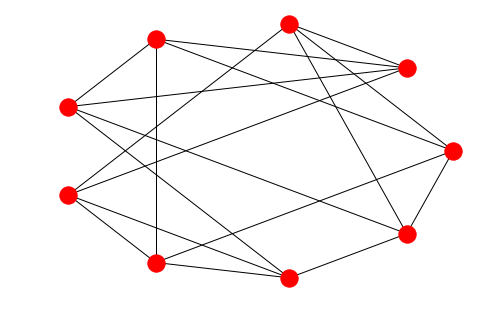

In [21]:
# take a look at our result
G = nx.from_numpy_matrix(A) 
nx.draw_circular(G, with_labels=False)

In [24]:
write_dot(G,'Paley9412.dot')